In [9]:
import gzip
import pickle
from pathlib import Path
from typing import Tuple, Callable, Optional

import numpy as np
import requests
import torch
import torch.nn.functional as F
from matplotlib import pyplot
from torch import Tensor, nn, optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import TensorDataset, DataLoader

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"


def download_data() -> Tuple[Tensor, ...]:
    PATH.mkdir(parents=True, exist_ok=True)
    if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
    with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        print(x_train, y_train)
        print(x_train.shape)
        print(y_train.min(), y_train.max())
        return tuple(map(torch.tensor, (x_train, y_train, x_valid, y_valid)))


def show_data_example(x_train: Tensor) -> None:
    pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
    pyplot.show()
    print(x_train.shape)


class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))


def get_data(train_ds: TensorDataset, valid_ds: TensorDataset, bs: int):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )


def loss_batch(model: nn.Module, loss_func: Callable, xb: Tensor, yb: Tensor, opt: Optional[Optimizer] = None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def fit(epochs: int, model: nn.Module, loss_func: Callable, opt: Optimizer, train_dl: DataLoader, valid_dl: DataLoader):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)


def main(epochs=5):
    x_train, y_train, x_valid, y_valid = download_data()
    show_data_example(x_train)

    train_ds = TensorDataset(x_train, y_train)
    valid_ds = TensorDataset(x_valid, y_valid)

    bs = 64
    train_dl, valid_dl = get_data(train_ds, valid_ds, bs)

    lr = 0.1
    model = Mnist_CNN()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    loss_func = F.cross_entropy

    fit(epochs, model, loss_func, opt, train_dl, valid_dl)
    return model

if __name__ == '__main__':
    True

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [5 0 4 ... 8 4 8]
(50000, 784)
0 9


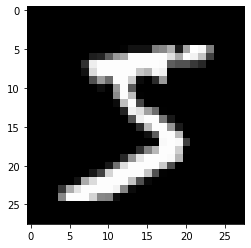

torch.Size([50000, 784])
0 0.3216199948787689
1 0.2210088433623314
2 0.19706316496133805
3 0.159561971950531
4 0.16511170368790626


In [10]:
modl = main()

In [11]:
modl

Mnist_CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)